In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'hand_landmarks_end.csv'
#model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
#tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X, y_train, y = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test, X_validation, y_test, y_validation = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 2, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 640)               0

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


48/53 [==========================>...] - ETA: 0s - loss: 2.8248 - accuracy: 0.1427
Epoch 1: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 3s 17ms/step - loss: 2.7627 - accuracy: 0.1560 - val_loss: 1.8347 - val_accuracy: 0.4532
Epoch 2/1000
14/53 [======>.......................] - ETA: 0s - loss: 1.9072 - accuracy: 0.3711

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/53 [==========================>...] - ETA: 0s - loss: 1.5330 - accuracy: 0.4815
Epoch 2: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 10ms/step - loss: 1.5069 - accuracy: 0.4874 - val_loss: 0.7762 - val_accuracy: 0.8104
Epoch 3/1000
50/53 [===========================>..] - ETA: 0s - loss: 0.8453 - accuracy: 0.7030
Epoch 3: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 11ms/step - loss: 0.8355 - accuracy: 0.7058 - val_loss: 0.4010 - val_accuracy: 0.8821
Epoch 4/1000
47/53 [=========================>....] - ETA: 0s - loss: 0.5646 - accuracy: 0.8037
Epoch 4: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1s 12ms/step - loss: 0.5539 - accuracy: 0.8061 - val_loss: 0.2405 - val_accuracy: 0.9595
Epoch 5/1000
51/53 [===========================>..] - ETA: 0s - loss: 0.4156 - accuracy: 0.8511
Epoch 5: saving model to new_hand_classifier.hdf5
53/53 [==============================] 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

16/16 [==============================] - 0s 5ms/step - loss: 3.3606e-04 - accuracy: 1.0000


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 311ms/step
[2.46625419e-33 4.26254155e-06 9.99995708e-01 6.54887657e-14
 2.25843094e-11 4.65699392e-14 1.71845047e-12 4.27253841e-17
 1.14250624e-22 1.50739026e-17 1.36355766e-36 5.07200239e-25
 2.31965267e-18 1.04081954e-22 1.55032514e-15 4.67719382e-21
 1.32802297e-22 3.08071250e-13 3.96556198e-29 1.59578167e-25
 9.67050238e-31 3.49584031e-25 1.59561434e-21 2.13769980e-16
 2.52401791e-25 3.68886782e-24]
2


# Confusion matrix

63/63 [==============================] - 0s 4ms/step


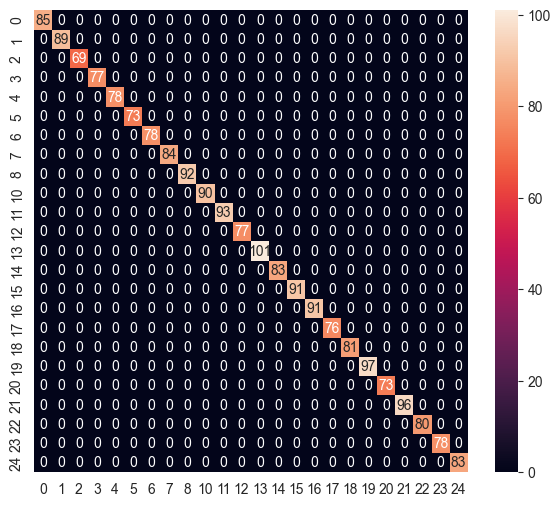

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        69
           3       1.00      1.00      1.00        77
           4       1.00      1.00      1.00        78
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        92
          10       1.00      1.00      1.00        90
          11       1.00      1.00      1.00        93
          12       1.00      1.00      1.00        77
          13       1.00      1.00      1.00       101
          14       1.00      1.00      1.00        83
          15       1.00      1.00      1.00        91
          16       1.00      1.00      1.00        91
          17       1.00      1.00      1.00        76
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp4p98ub3b\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp4p98ub3b\assets


105472

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 7.54 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.08954168e-33 3.55228985e-06 9.99996424e-01 6.18953199e-14
 1.77923856e-11 3.63852726e-14 1.60643276e-12 3.55372739e-17
 1.03148031e-22 1.14298510e-17 1.42286115e-36 4.30573791e-25
 1.86610685e-18 7.75327081e-23 1.60706163e-15 4.75052572e-21
 1.16977924e-22 2.40214722e-13 3.19320990e-29 1.67651123e-25
 6.82130861e-31 3.15250117e-25 1.37121050e-21 2.45951236e-16
 2.11198871e-25 3.37978146e-24]
2


In [23]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpm7f72lbj\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpm7f72lbj\assets


#### Loss  (cost)

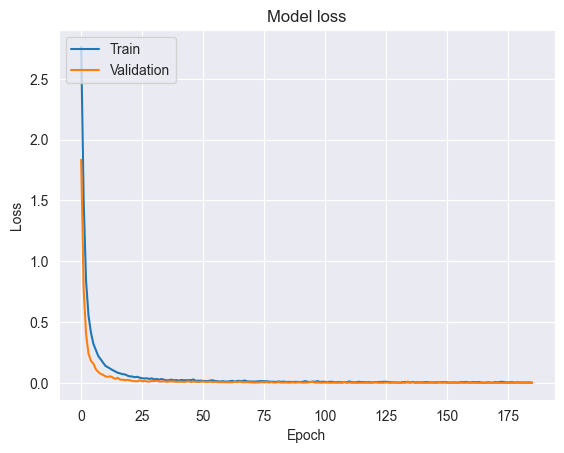

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

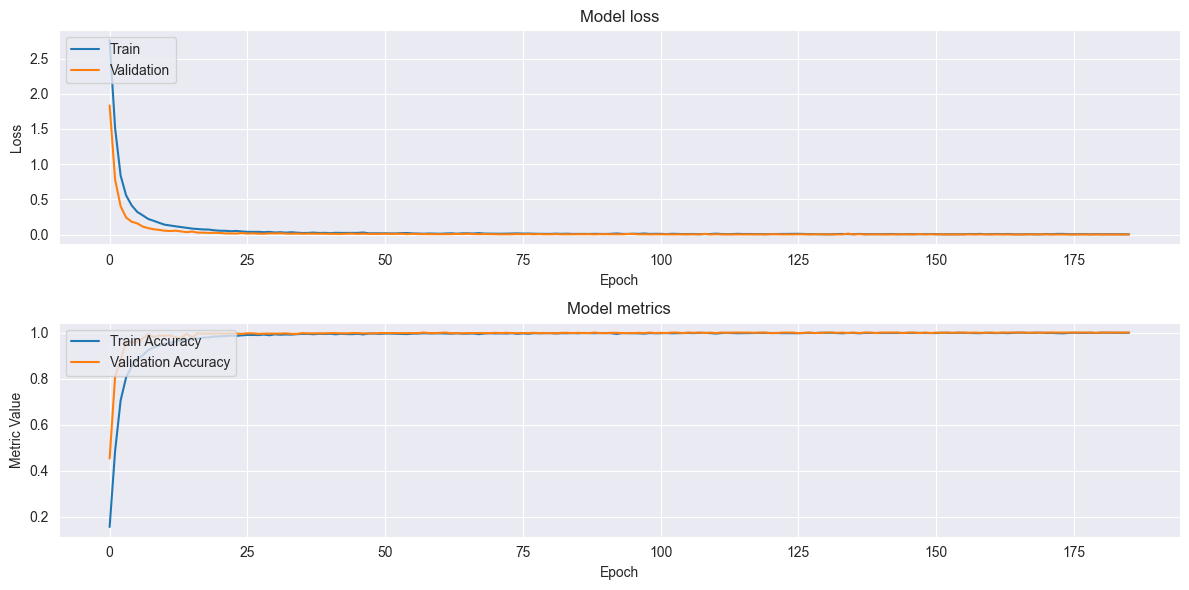

In [25]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

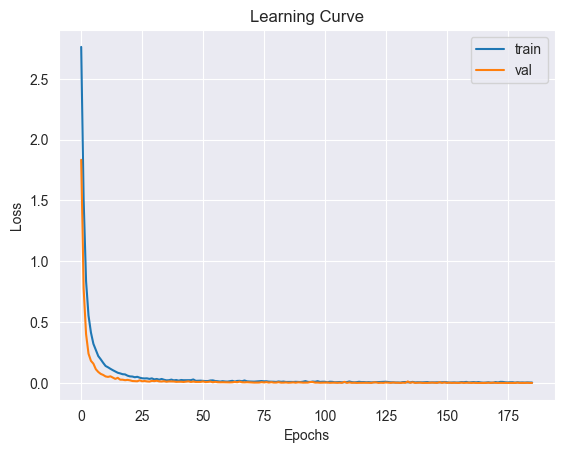

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()